# 04 - Applied ML

# Imports

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import networkx as nx

import sklearn.model_selection as ms

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import ShuffleSplit

from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import metrics

%matplotlib inline

# Constants definition

In [2]:
DATA_PATH = "./data"

 # Question 1: Propensity score matching

In [70]:
df = pd.read_csv("{}/lalonde.csv".format(DATA_PATH))
df.set_index('id', drop=True, inplace=True)

In [71]:
#df['outcome'] = np.where( (df['re78'] - df['re75']) > 0 , 1, 0)

In [72]:
df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
id,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [73]:
df.corr()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
treat,1.000000,-0.102893,0.019308,0.600907,-0.117983,-0.301334,0.105857,-0.249779,-0.130197,-0.039033
age,-0.102893,1.000000,-0.125622,-0.110730,-0.053400,0.376059,-0.069218,0.333254,0.140022,0.106249
educ,0.019308,-0.125622,1.000000,-0.010528,-0.174153,-0.095051,-0.701452,0.136583,0.018301,0.161538
black,0.600907,-0.110730,-0.010528,1.000000,-0.294973,-0.317118,0.109278,-0.257334,-0.140374,-0.120977
hispan,-0.117983,-0.053400,-0.174153,-0.294973,1.000000,0.021549,0.100869,-0.007091,0.061589,0.015325
married,-0.301334,0.376059,-0.095051,-0.317118,0.021549,1.000000,-0.032349,0.425739,0.353824,0.162358
nodegree,0.105857,-0.069218,-0.701452,0.109278,0.100869,-0.032349,1.000000,-0.208751,-0.070412,-0.142418
re74,-0.249779,0.333254,0.136583,-0.257334,-0.007091,0.425739,-0.208751,1.000000,0.552002,0.343416
re75,-0.130197,0.140022,0.018301,-0.140374,0.061589,0.353824,-0.070412,0.552002,1.000000,0.257659
re78,-0.039033,0.106249,0.161538,-0.120977,0.015325,0.162358,-0.142418,0.343416,0.257659,1.000000


### 1. a naive approach

In [118]:
treated = df[df["treat"] == 1]
control = df[df["treat"] == 0]

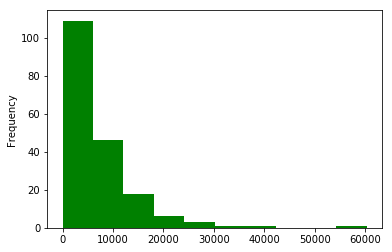

In [119]:
treated['re78'].plot(kind='hist', color='green')

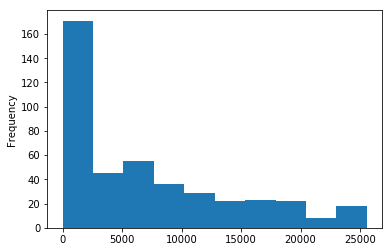

In [120]:
control['re78'].plot(kind='hist')

If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

In [121]:
stats.ks_2samp(treated['re78'],control['re78'])

Ks_2sampResult(statistic=0.098607698607698691, pvalue=0.15279452288468109)

### 2. A closer look at the data

We will get a closer look to the data by analyzing the covariates instead of stopping at the output as we did in the previous example. The covariates we will cover are:

In the following graph we will compare the distributions of thoe variables in the two groups, the treatment and the control.

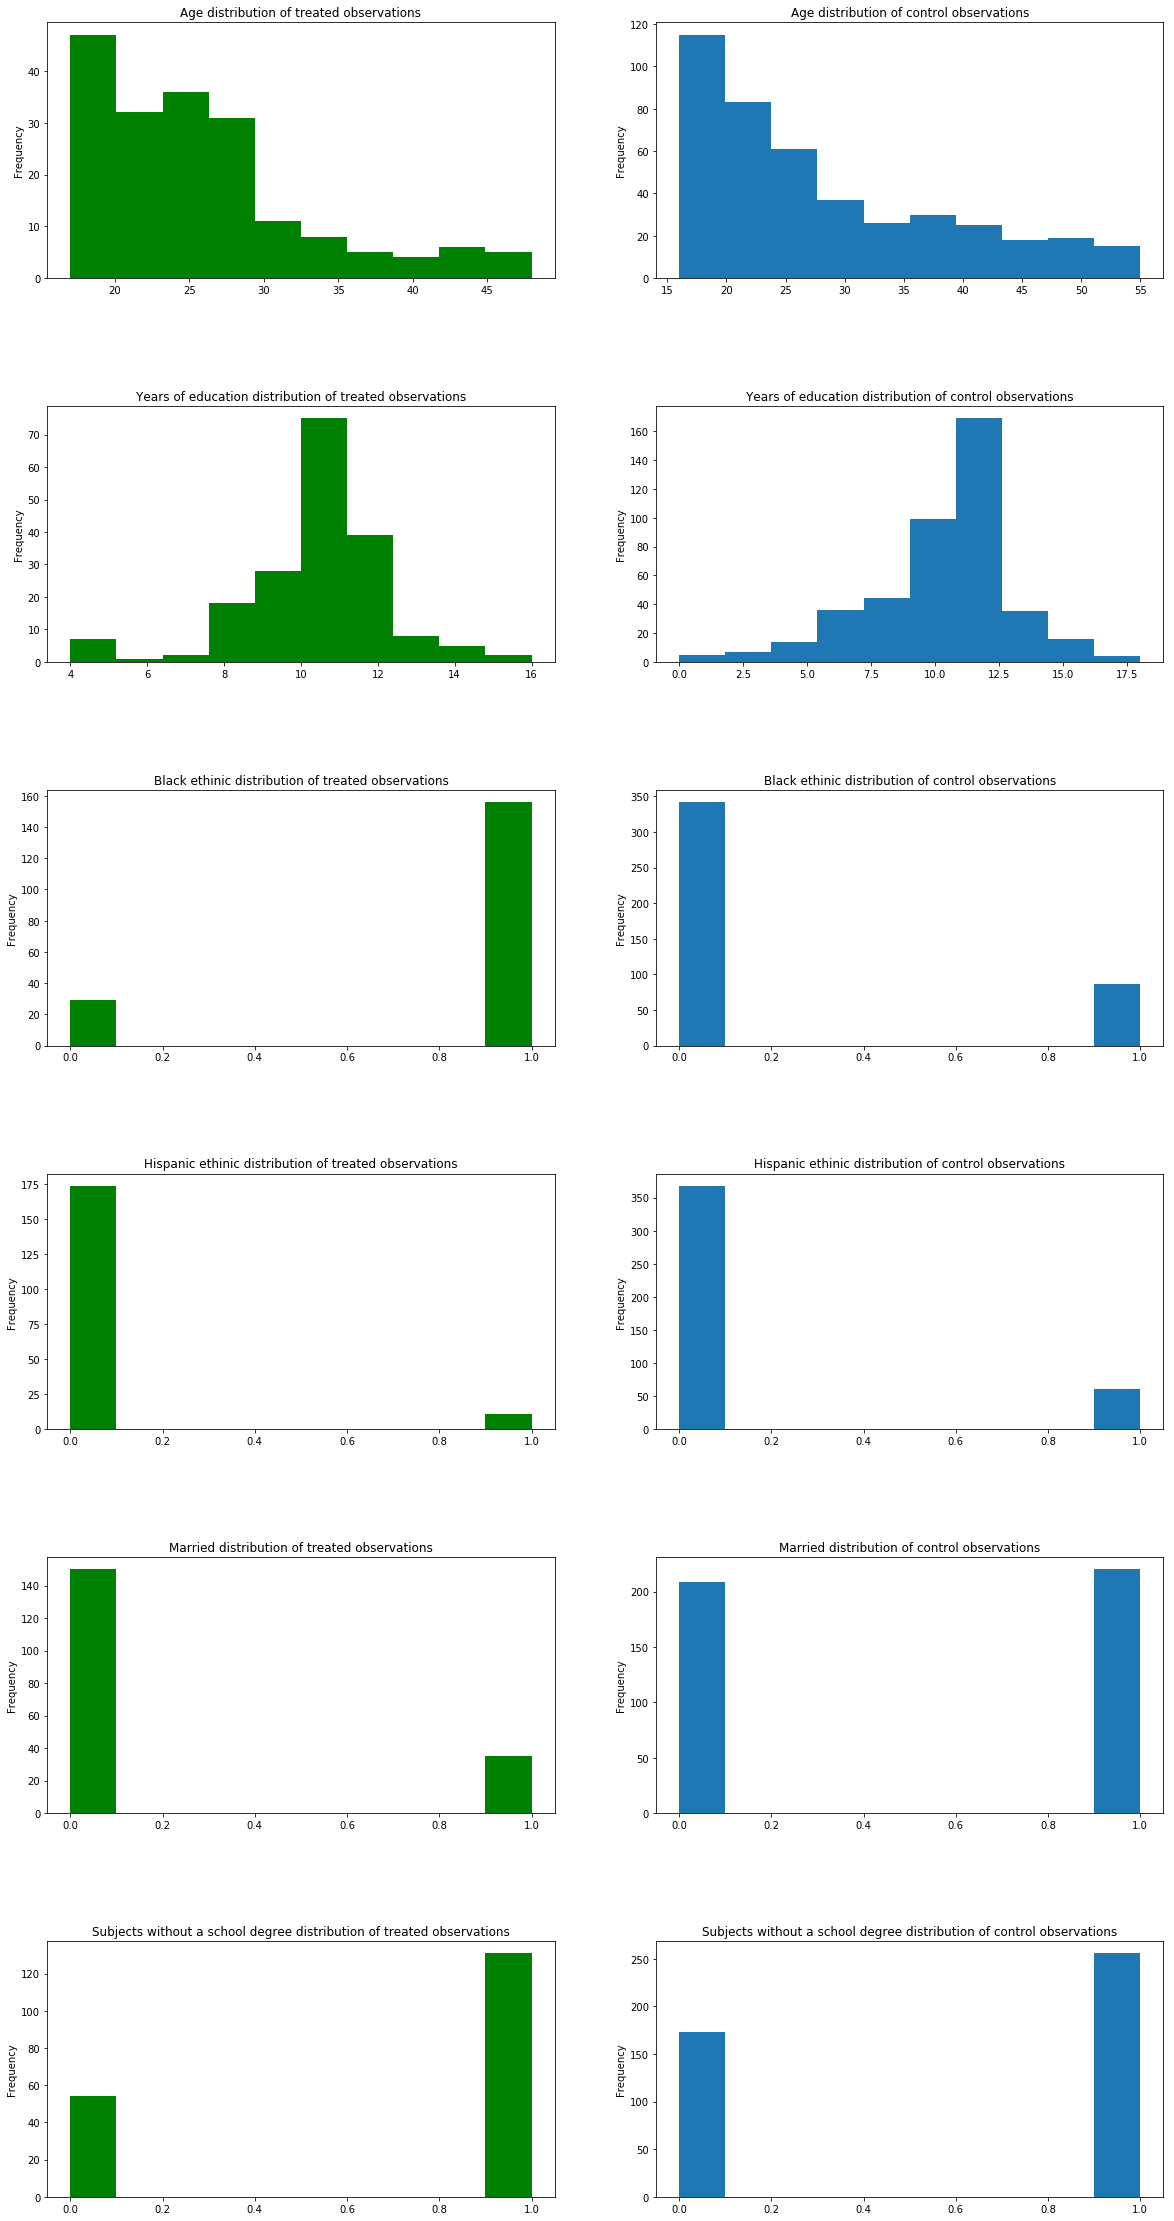

In [122]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(20, 40))
fig.subplots_adjust(hspace=.5)

treated['age'].plot(kind='hist', ax=axes.flat[0], 
                    title='Age distribution of treated observations', color='green')
control['age'].plot(kind='hist', ax=axes.flat[1], 
                    title='Age distribution of control observations')


treated['educ'].plot(kind='hist', ax=axes.flat[2], 
                     title='Years of education distribution of treated observations', color='green')
control['educ'].plot(kind='hist', ax=axes.flat[3], 
                     title='Years of education distribution of control observations')


treated['black'].plot(kind='hist', ax=axes.flat[4], 
                      title='Black ethinic distribution of treated observations', color='green')
control['black'].plot(kind='hist', ax=axes.flat[5], 
                      title='Black ethinic distribution of control observations')


treated['hispan'].plot(kind='hist', ax=axes.flat[6], 
                       title='Hispanic ethinic distribution of treated observations', color='green')
control['hispan'].plot(kind='hist', ax=axes.flat[7], 
                       title='Hispanic ethinic distribution of control observations')


treated['married'].plot(kind='hist', ax=axes.flat[8], 
                        title='Married distribution of treated observations', color='green')
control['married'].plot(kind='hist', ax=axes.flat[9], 
                        title='Married distribution of control observations')


treated['nodegree'].plot(kind='hist', ax=axes.flat[10], 
                         title='Subjects without a school degree distribution of treated observations', color='green')
control['nodegree'].plot(kind='hist', ax=axes.flat[11], 
                         title='Subjects without a school degree distribution of control observations')

To make it more formal, we will compute again the K-S Test for the different distributions and compare them on that. The result is shown on a full dataframe

In [115]:
variables = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree']
ks_test_df = pd.DataFrame(columns=['Variable', 'K-S Test statistics', 'K-S Test p-value'])

for v in variables:
    # compute the K-S Test statistic for the v-th variable
    ks = stats.ks_2samp(treated[v], control[v])
    
    # append the results tot he dataframe
    s = pd.Series([v, ks[0], ks[1]],index=['Variable','K-S Test statistics', 'K-S Test p-value'])
    ks_test_df = ks_test_df.append(s, ignore_index=True)
    
ks_test_df

,Variable,K-S Test statistics,K-S Test p-value
0,age,0.157727,2.778749e-03
1,educ,0.111372,7.524345e-02
2,black,0.640446,1.561109e-47
3,hispan,0.082732,3.258649e-01
4,married,0.323631,1.871118e-12
5,nodegree,0.111372,7.524345e-02


Since the p-values are as shown in the dataset we can reject the null hypothesis (the distributions of the two samples are the same) since the pvalue is below 1%

### 3. A propensity score model

In the propensity score we want to obtain the probability to be under treatment according to the different covariates. In this case we will use the Logistic Regression Classifier to obtain a model for such task

In [9]:
logistic = LogisticRegression()

The differen covariates of this problem are the following:

In [10]:
features = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree']

In [11]:
# The features vector
X = pd.get_dummies(df[features])
X.head()

,age,educ,black,hispan,married,nodegree
id,,,,,,
NSW1,37,11,1,0,1,1
NSW2,22,9,0,1,0,1
NSW3,30,12,1,0,0,0
NSW4,27,11,1,0,0,1
NSW5,33,8,1,0,0,1


We want to compute the probability of the treatment over the covariates. Our target will therefore be the treatment data

In [12]:
y = df['treat']

In [13]:
logistic.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [14]:
logistic.classes_

array([0, 1])

In [15]:
pred = logistic.predict_proba(X)

df['propensity score'] = pred[:, 1]

df.head()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,outcome,propensity score
id,,,,,,,,,,,,
NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460,1,0.473938
NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940,1,0.200786
NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500,1,0.642152
NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460,1,0.695664
NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899,1,0.677198


### 4. Balancing the dataset via matching

In [16]:
G = nx.Graph()
G.add_nodes_from([1,2,3,4], bipartite=0) # Add the node attribute "bipartite"
G.add_nodes_from(['a','b','c'], bipartite=1)
G.add_edges_from([(1,'a'), (1,'b'), (2,'b'), (2,'c'), (3,'c'), (4,'a')])

In [17]:
treated = df[df['treat'] == 1]['propensity score']
control = df[df['treat'] == 0]['propensity score']

In [18]:
B = nx.Graph()

B.add_nodes_from(treated[:5], bipartite=0)
B.add_nodes_from(control[:5], bipartite=1)

/Users/mfeo15/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/Users/mfeo15/anaconda/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/Users/mfeo15/anaconda/lib/python3.6/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/Users/mfeo15/anaconda/lib/python3.6/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold i

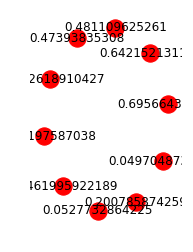

In [19]:
plt.subplot(121)
nx.draw(B, with_labels=True, font_weight='regular')

In [20]:
from networkx.algorithms import bipartite
a, b = bipartite.sets(B)

In [21]:
a

set()

In [22]:
nx.bipartite.maximum_matching(B)

{}

 # Question 2: Applied ML

### 1)

In [23]:
newsgroups = fetch_20newsgroups(data_home='{}/'.format(DATA_PATH) ,subset='all')

In [24]:
print(newsgroups.data[1], end="\n\n")

From: mblawson@midway.ecn.uoknor.edu (Matthew B Lawson)
Subject: Which high-performance VLB video card?
Summary: Seek recommendations for VLB video card
Nntp-Posting-Host: midway.ecn.uoknor.edu
Organization: Engineering Computer Network, University of Oklahoma, Norman, OK, USA
Keywords: orchid, stealth, vlb
Lines: 21

  My brother is in the market for a high-performance video card that supports
VESA local bus with 1-2MB RAM.  Does anyone have suggestions/ideas on:

  - Diamond Stealth Pro Local Bus

  - Orchid Farenheit 1280

  - ATI Graphics Ultra Pro

  - Any other high-performance VLB card


Please post or email.  Thank you!

  - Matt

-- 
    |  Matthew B. Lawson <------------> (mblawson@essex.ecn.uoknor.edu)  |   
  --+-- "Now I, Nebuchadnezzar, praise and exalt and glorify the King  --+-- 
    |   of heaven, because everything he does is right and all his ways  |   
    |   are just." - Nebuchadnezzar, king of Babylon, 562 B.C.           |   




In [45]:
type(newsgroups)

sklearn.datasets.base.Bunch

In [42]:
newsgroups.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [61]:
tf = TfidfVectorizer(newsgroups.data)
tfidf_matrix = tf.fit_transform(newsgroups.data)
feature_names = tf.get_feature_names()

In [56]:
tfidf_matrix.shape

(18846, 173762)

In [69]:
feature_names[100:120]

['000256',
 '0003',
 '000337',
 '000359',
 '0004',
 '000406',
 '000410',
 '00041032',
 '000413',
 '0004136',
 '00041555',
 '0004244402',
 '0004246',
 '00043819',
 '0004422',
 '00044513',
 '00044808',
 '00044939',
 '0004651657',
 '0004847546']

In [33]:
rs = ShuffleSplit(n_splits=1, train_size=0.8, test_size=0.1)
rs.get_n_splits(newsgroups)

1

In [51]:
for train_index, test_index in rs.split(newsgroups):

SyntaxError: unexpected EOF while parsing (<ipython-input-51-f9048c0c0a9b>, line 1)

### 2)

In [27]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

In [28]:
newsgroups_test = fetch_20newsgroups(data_home='{}/'.format(DATA_PATH) ,subset='test')
vectors_test = vectorizer.transform(newsgroups_train.data)

clf.fit(vectors, newsgroups_train.target)
pred = clf.predict(vectors_test)

metrics.f1_score(newsgroups_test.target, pred, average='macro')

NameError: name 'newsgroups_train' is not defined